In [1]:
import random
from collections import deque
from copy import deepcopy

import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from IPython.display import clear_output

In [2]:
SEED = 1
BATCH_SIZE = 256
LR = 0.00030
UP_COEF = 0.1
GAMMA = 0.99
V_MAX = 10
V_MIN = -10
N_ATOMS = 51
DELTA_Z = (V_MAX - V_MIN) / (N_ATOMS - 1)

# set device
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

# random seed
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if use_cuda:
    torch.cuda.manual_seed_all(SEED)

In [3]:
class CategoricalDuelingDQN(nn.Module):
    def __init__(self, obs_space, action_space, n_atoms):
        super().__init__()
        H = 512
        self.head = nn.Sequential(
            nn.Linear(obs_space, obs_space*10),
            nn.SELU()
        )
        self.val = nn.Sequential(
            nn.Linear(obs_space*10, H),
            nn.SELU(),
            nn.Linear(H, H),
            nn.SELU(),
            nn.Linear(H, n_atoms)
        )
        self.adv = nn.Sequential(
            nn.Linear(obs_space*10, H),
            nn.SELU(),
            nn.Linear(H, H),
            nn.SELU(),
            nn.Linear(H, action_space * n_atoms)
        )
        self.log_softmax = nn.LogSoftmax(dim=-1)
        self.register_buffer(
            'support', torch.arange(V_MIN, V_MAX + DELTA_Z, DELTA_Z))

    def forward(self, x):
        out = self.head(x)
        val_out = self.val(out).reshape(out.shape[0], 1, N_ATOMS)
        adv_out = self.adv(out).reshape(out.shape[0], -1, N_ATOMS)
        adv_mean = adv_out.mean(dim=1, keepdim=True)
        out = val_out + adv_out - adv_mean
        log_p = self.log_softmax(out)

        return log_p

In [4]:
losses = []


def learn(net, tgt_net, optimizer, rep_memory):
    net.train()
    tgt_net.train()

    dataloader = DataLoader(rep_memory,
                            batch_size=BATCH_SIZE,
                            shuffle=True,
                            pin_memory=use_cuda)
    # like a double DQN
    for i, (s, a, r, _s, d) in enumerate(dataloader):
        if i > 0:
            break
        s_batch = s.to(device).float()
        a_batch = a.to(device).long()
        _s_batch = _s.to(device).float()
        r_batch = r.to(device).float()
        done_mask = d.to(device).float()

        log_p_batch = net(_s_batch)
        _weights = log_p_batch.exp() * net.support
        _q_batch = _weights.sum(dim=2)
        _a_batch = torch.argmax(_q_batch, dim=1)

        with torch.no_grad():
            log_p_batch_tgt = tgt_net(_s_batch)
            log_p_best = log_p_batch_tgt[range(BATCH_SIZE), _a_batch]
            _p_proj = projection(log_p_best.exp(), r_batch, done_mask)

        log_p_batch = net(s_batch)
        log_p_acting = log_p_batch[range(BATCH_SIZE), a_batch]

        # loss
        loss = -(_p_proj * log_p_acting).sum(dim=1).mean()
        losses.append(loss)

        optimizer.zero_grad()
        loss.backward()
#         nn.utils.clip_grad_norm_(net.parameters(), max_norm=0.5)
        optimizer.step()


def projection(_p_a, r, d):
    _p_proj = np.zeros((BATCH_SIZE, N_ATOMS), dtype=np.float32)
    r_np = r.cpu().numpy()
    d_np = d.cpu().numpy()
    _p_a_np = _p_a.cpu().numpy()
    batch_id = range(BATCH_SIZE)
    for i in range(N_ATOMS):
        z = np.clip(r_np + GAMMA * (1 - d_np) * (V_MIN + i * DELTA_Z),
                    V_MIN, V_MAX)
        b = (z - V_MIN) / DELTA_Z
        l = np.floor(b).astype(np.int64)
        u = np.ceil(b).astype(np.int64)
        _p_proj[batch_id, l[batch_id]] += d_np + _p_a_np[batch_id, i] * (u - b)[batch_id] * (1 - d_np)
        _p_proj[batch_id, u[batch_id]] += d_np + _p_a_np[batch_id, i] * (b - l)[batch_id] * (1 - d_np)
        
    _p_proj = _p_proj / _p_proj.sum(axis=1, keepdims=1)
    
    return torch.tensor(_p_proj).to(device).float()


def select_action(obs, tgt_net):
    tgt_net.eval()
    with torch.no_grad():
        state = torch.tensor([obs]).to(device).float()
        log_p = target_net(state)
        weights = log_p.exp() * net.support
        q = weights.sum(dim=2)
        action = torch.argmax(q, dim=1)

    return action.item()


def plot():
    clear_output(True)
    plt.figure(figsize=(16, 5))
    plt.subplot(121)
    plt.plot(rewards)
    plt.title('Reward')
    plt.subplot(122)
    plt.plot(losses)
    plt.title('Loss')
    plt.show()

## Main

In [ ]:
# make an environment
# env = gym.make('Breakout-ram-v0')
# env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('LunarLander-v2')

env.seed(SEED)
obs_space = env.observation_space.shape[0]
action_space = env.action_space.n

# hyperparameter
n_episodes = 1000
learn_start = 1500
memory_size = 50000
update_frq = 1
use_eps_decay = False
epsilon = 1.0
eps_min = 0.001
decay_rate = 0.0001
n_eval = env.spec.trials

# global values
total_steps = 0
learn_steps = 0
rewards = []
reward_eval = deque(maxlen=n_eval)
is_learned = False
is_solved = False

# make two nerual networks
net = CategoricalDuelingDQN(obs_space, action_space, N_ATOMS).to(device)
target_net = deepcopy(net)

# make a optimizer
optimizer = optim.Adam(net.parameters(), lr=LR, eps=1e-8)

# make memory
rep_memory = deque(maxlen=memory_size)

/home/jay/anaconda3/lib/python3.7/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [ ]:
use_cuda

True

In [ ]:
env.spec.max_episode_steps

500

In [ ]:
env.spec.trials

100

In [ ]:
env.spec.reward_threshold

475.0

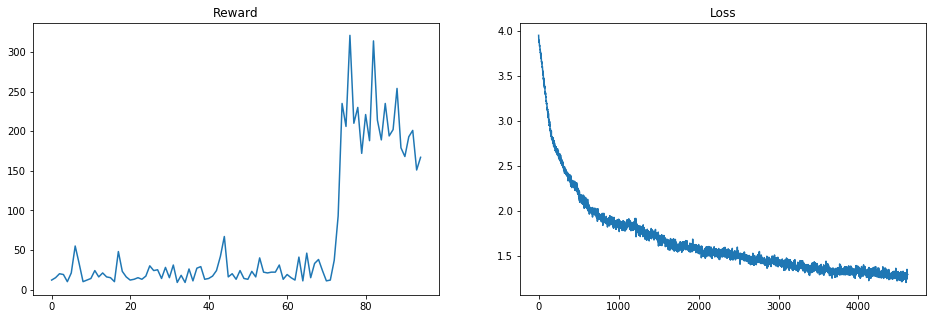

In [ ]:
# play
for i in range(1, n_episodes + 1):
    obs = env.reset()
    done = False
    ep_reward = 0
    while not done:
#         env.render()
        if np.random.rand() < epsilon:
            action = env.action_space.sample()
        else:
            action = select_action(obs, target_net)

        _obs, reward, done, _ = env.step(action)

        rep_memory.append((obs, action, reward, _obs, done))

        obs = _obs
        total_steps += 1
        ep_reward += reward

        if use_eps_decay:
            epsilon -= epsilon * decay_rate
            epsilon = max(eps_min, epsilon)

        if len(rep_memory) >= learn_start:
            if len(rep_memory) == learn_start:
                print('\n============  Start Learning  ============\n')
                epsilon = eps_min
            learn(net, target_net, optimizer, rep_memory)
            learn_steps += 1

        if learn_steps == update_frq:
            # target smoothing update
            for t, n in zip(target_net.parameters(), net.parameters()):
                t.data = UP_COEF * n.data + (1 - UP_COEF) * t.data
#             target_net.load_state_dict(net.state_dict())
            learn_steps = 0

    if done:
        rewards.append(ep_reward)
        reward_eval.append(ep_reward)
        plot()
#         print('{:3} Episode in {:5} steps, reward {:.2f}'.format(
#             i, total_steps, ep_reward))

        if len(reward_eval) >= n_eval:
            if np.mean(reward_eval) >= env.spec.reward_threshold:
                print('\n{} is sloved! {:3} Episode in {:3} steps'.format(
                    env.spec.id, i, total_steps))
                torch.save(target_net.state_dict(),
                           f'./test/saved_models/{env.spec.id}_ep{i}_clear_model_cdddqn.pt')
                break
env.close()

In [ ]:
[
    ('CartPole-v0', 385, 0.05),
    ('CartPole-v1', None, 0.05),
    ('MountainCar-v0', None, 0.1),
    ('LunarLander-v2', None, 0.1)
]